In [36]:
#default_exp poi.train

In [37]:
from speechsep.imports import *
from speechsep.data import *
from speechsep.core import *
from speechsep.masks import *
from speechsep.utils import *
from speechsep.models import *

In [38]:
from speechsep.base import *

# From the start

In [39]:
def files2mask(files):
    tfms = [AudioMono.create, Resample(22050), Clip(5)]
    audios = [compose_tfms(f, tfms) for f in files]
    aud2mask = Maskify(MaskBinary)
    mixed_spec, masks = aud2mask(audios)
    return [mixed_spec, masks[0]]

In [40]:
class POIMesher:
    def __init__(self, poi):
        self.poi = poi

    def get_poi_files(self, path):
        return get_audio_files(path, folders=f"{self.poi}")

    def get_non_poi_files(self, path):
        files = get_audio_files(path)
        poi_path = path/str(self.poi)
        return [file for file in files if poi_path not in list(file.parents)]

    def __call__(self, path):
        rand_poi = []
        poi_files = self.get_poi_files(path)
        non_poi_files = self.get_non_poi_files(path)
        for x in range(len(non_poi_files)):
            rand_poi.append(random.choice(poi_files))
        return list(map(list,zip(rand_poi, non_poi_files)))

In [41]:
class SpecMaskDataset(torch.utils.data.Dataset):
    def __init__(self, files):
        self.files = files
        self.tensorify = ToTensor()
        self.trim = Unet_Trimmer(16)
        
    def __getitem__(self, i):
        spec, mask = files2mask(self.files[i])
        spec, mask = self.tensorify(spec), self.tensorify(mask)
        return self.trim(spec[:1]), self.trim(mask)
    
    def __len__(self): return len(self.files)

In [42]:
poi = "911"
fn = Path("/home/cerberus/Music/LibriSpeech/train-clean-100/")

files = POIMesher(poi)(fn)
train_ds = SpecMaskDataset(files[:-6000])
valid_ds = SpecMaskDataset(files[-6000:])

dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=2).cuda()

# Load training

In [43]:
model = U_Net(img_ch=1, output_ch=1).cuda()

In [44]:
def custom_loss(inp, targ):
    targ = targ[:,None,:,:].permute(0,1,3,2)
    return BCEWithLogitsLossFlat()(inp, targ)*10

In [45]:
learn = Learner(dls, model, loss_func=custom_loss)

In [46]:
learn.load("TrainBinary_2e_9")

In [47]:
def listen2spec(spec):
    zeros = torch.zeros_like(spec)
    spec = torch.cat((spec, zeros),0)
    cplx_spec = real2complex(spec)
    specbase = SpecBase(cplx_spec, 22050)
    
    return Spectify().decode(specbase)

def createMask(mask, threshold=1):
    return MaskBinary(mask.numpy(), threshold)

# Tests (No phase)

In [48]:
i = 0; threshold = 0.5

In [49]:
AudioMono.create(dls.files[i][1])

/home/cerberus/Music/LibriSpeech/train-clean-100/3699/19401/3699-19401-0022.flac, 13.68secs at 22050 samples per second

In [50]:
listen2spec(dls.dataset[i][0].cpu())

None, 4.85297052154195secs at 22050 samples per second

In [51]:
mask = learn.predict([dls.dataset[i][0]])[0].cpu()
mask = createMask(mask)

In [52]:
listen2spec(dls.dataset[i][0].cpu()*mask)

None, 4.85297052154195secs at 22050 samples per second

In [53]:
target = dls.dataset[i][1].T.cpu()
target = createMask(target[None,:,:])

In [54]:
listen2spec(dls.dataset[i][0].cpu()*target)

None, 4.85297052154195secs at 22050 samples per second

<AxesSubplot:>

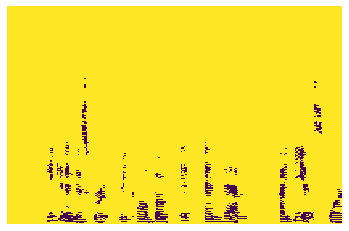

In [55]:
MaskBinary(target.data[0].T[:512]).show()

<AxesSubplot:>

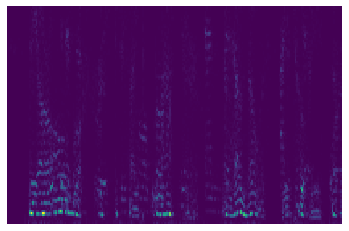

In [56]:
dls.dataset[i][0].show()

# Final Test

In [57]:
dls.files[0]

[Path('/home/cerberus/Music/LibriSpeech/train-clean-100/911/128684/911-128684-0012.flac'),
 Path('/home/cerberus/Music/LibriSpeech/train-clean-100/3699/19401/3699-19401-0022.flac')]

In [58]:
tfms = [AudioMono.create, Resample(22050), Clip(5)]
audios = [compose_tfms(f, tfms) for f in dls.files[0]]
audios

[/home/cerberus/Music/LibriSpeech/train-clean-100/911/128684/911-128684-0012.flac, 5.0secs at 22050 samples per second,
 /home/cerberus/Music/LibriSpeech/train-clean-100/3699/19401/3699-19401-0022.flac, 5.0secs at 22050 samples per second]

In [59]:
mixed = AudioMono(audios[0].sig+audios[1].sig, audios[0].sr)
mixed

None, 5.0secs at 22050 samples per second

<AxesSubplot:>

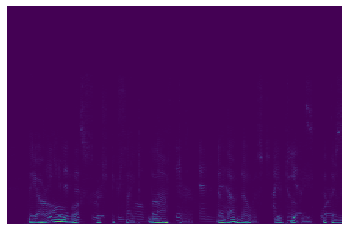

In [60]:
spec = Spectify()(mixed)
spec.show()

In [61]:
Spectify().decode(spec)

None, 4.992290249433107secs at 22050 samples per second

In [62]:
final_test = dls.dataset[i][1].cpu().numpy()

In [63]:
trimmed_spec = SpecImage(spec.data[:,:208], spec.sr)

<AxesSubplot:>

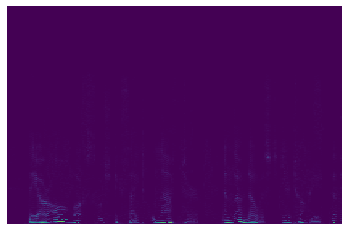

In [64]:
result = trimmed_spec*MaskBinary(final_test)
result.show()

In [65]:
Spectify().decode(result)

None, 4.85297052154195secs at 22050 samples per second

<AxesSubplot:>

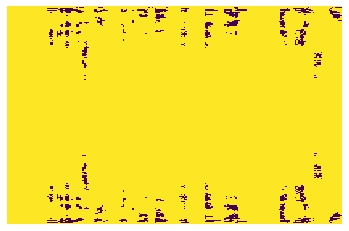

In [66]:
MaskBinary(final_test).show()

In [67]:
def npsigmoid(z):
    return 1/(1 + np.exp(-z))

<AxesSubplot:>

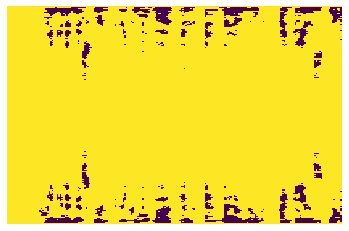

In [68]:
mask = npsigmoid(learn.predict([dls.dataset[i][0]])[0].cpu().numpy())
MaskBinary(mask[0].T>0.9).show()

<AxesSubplot:>

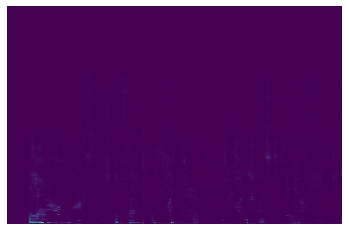

In [69]:
result = trimmed_spec*MaskBinary(mask[0].T>0.9)
result.show()

In [70]:
Spectify().decode(result)

None, 4.85297052154195secs at 22050 samples per second